In [1]:
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.callbacks import TensorBoard
import time 
import numpy as np
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import  MaxPooling1D

This is a model to simulate the fisheries interaction, we uses oceanographic data, economical data, to forecast the catch for each fisheries in the  Souther Baja California State in Mexico. 
The data are set as follow:


In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
#importacion de los datos
dataset = read_csv('data (2).csv', header=0, index_col=0)
print(dataset.shape)

(161, 19)


In [4]:
values = dataset.values
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,:1])



C:\Users\ricar\anaconda3\Anaconnda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [5]:
delay = 6

In [6]:
# nos aseguramos de que todos los datos esten en formato numerico con punto 
#flotante de 32 ceros
values = values.astype('float32')
print(values.shape)

(161, 19)


In [7]:
# normalizamos los datos 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
#se aplica el delay
reframed = series_to_supervised(scaled, 1, delay)


In [8]:
lx,ly=reframed.shape
for i in range(1,ly):
    reframed.drop(reframed.columns[[ly-i]],axis=1,inplace=True)

In [9]:
# se dividen los datos en conjunto de entrenamiento y en conjunto de test
values = reframed.values
n_train_hours = len(reframed)-24#aquí divido asígno el numero de datos para test
train = values[:n_train_hours, :]#aquí separo los datos para el entrenamiento
test = values[n_train_hours:, :]#los datos para el test
#print(values.shape,train.shape,test.shape)
# split into input and outputs
train_X = train[:, :]
train_y = train[:,:16 ]#aquí seleccionas el vector correspondiente a pronóstico
test_X=  test[:, :]
test_y = test[:, :16]#idem
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


print(test_X.shape)


(24, 1, 1)


In [10]:
# design network
model = Sequential()
model.add(LSTM(150,return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Activation('linear'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2,padding='same'))
model.add(Dense(16))
model.add(LSTM(150,return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(LSTM(50,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.6))
model.add(Activation('linear'))
model.add(Dense(16))
model.compile(loss='mae', optimizer='adamax')





In [11]:
#model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
history = model.fit(train_X, train_y, epochs=500, batch_size=5,validation_data=(test_X, test_y),shuffle=False)


Epoch 1/500
27/27 [==============================] - 6s 72ms/step - loss: 0.1869 - val_loss: 0.1294
Epoch 2/500
27/27 [==============================] - 0s 4ms/step - loss: 0.1861 - val_loss: 0.1297
Epoch 3/500
27/27 [==============================] - 0s 4ms/step - loss: 0.1856 - val_loss: 0.1299
Epoch 4/500
27/27 [==============================] - 0s 4ms/step - loss: 0.1851 - val_loss: 0.1299
Epoch 5/500
27/27 [==============================] - 0s 4ms/step - loss: 0.1845 - val_loss: 0.1295
Epoch 6/500
27/27 [==============================] - 0s 4ms/step - loss: 0.1830 - val_loss: 0.1286
Epoch 7/500
27/27 [==============================] - 0s 4ms/step - loss: 0.1815 - val_loss: 0.1267
Epoch 8/500
27/27 [==============================] - 0s 4ms/step - loss: 0.1777 - val_loss: 0.1231
Epoch 9/500
27/27 [==============================] - 0s 4ms/step - loss: 0.1708 - val_loss: 0.1164
Epoch 10/500
27/27 [==============================] - 0s 4ms/step - loss: 0.1566 - val_loss: 0.1043
Epoch 11

In [12]:
#print(inv_y.reshape(22,1))
#print(inv_yhat.reshape(22,1))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 150)            91200     
_________________________________________________________________
dropout (Dropout)            (None, 1, 150)            0         
_________________________________________________________________
activation (Activation)      (None, 1, 150)            0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1, 150)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 150)            0         
_________________________________________________________________
dense (Dense)                (None, 1, 16)             2416      
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 150)            1

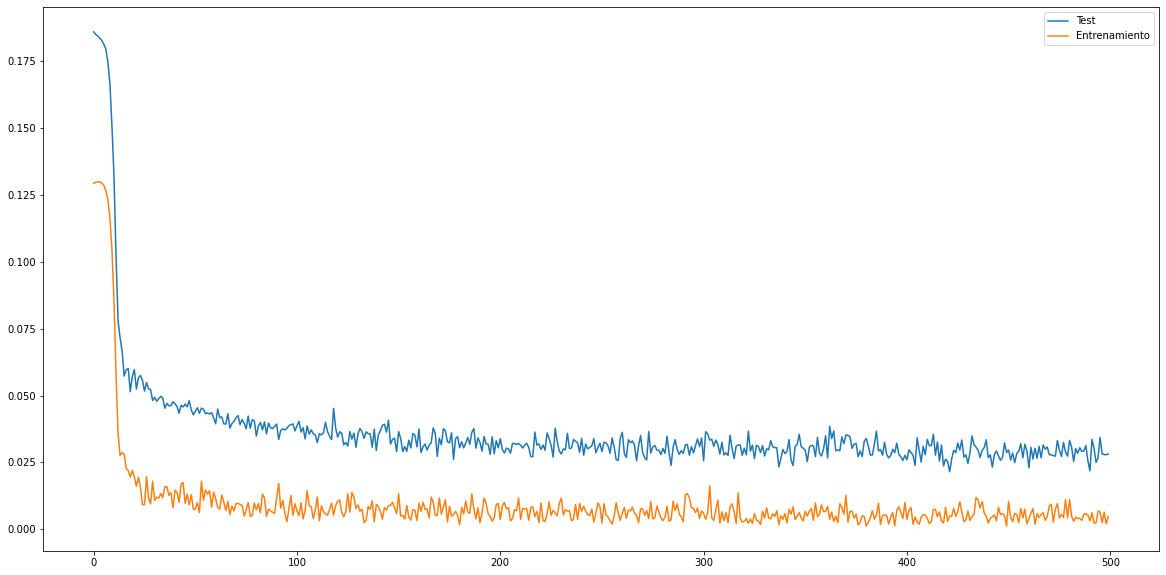

In [14]:
pyplot.figure(figsize=(20,10))
pyplot.plot(history.history['loss'], label='Test')
pyplot.plot(history.history['val_loss'], label='Entrenamiento')
pyplot.legend()
pyplot.show()
#fig.savefig('ent 3.png', bbox_inches='tight')

In [15]:
 #make a prediction
yhat = model.predict(test_X)


In [16]:
print(test_X.shape)
print(test_X.shape)

(24, 1, 1)
(24, 1, 1)


In [17]:
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X1[:, :8]), axis=1)
inv_yhat2 = scaler.inverse_transform(inv_yhat)
inv_yhat3 = inv_yhat2[:,]
# invert scaling for actual
test_y2 = test_y.reshape((len(test_y), 16))
inv_y = np.concatenate((test_y2, test_X1[:, :8]), axis=1)
inv_y2 = scaler.inverse_transform(inv_y)
inv_y3 = inv_y2[:16]

ValueError: operands could not be broadcast together with shapes (24,17) (19,) (24,17) 

In [ ]:
resul=DataFrame(inv_y3)
resul.to_csv('real_test.csv')

In [ ]:
prono=DataFrame(inv_yhat3)
prono.to_csv('pronostico.csv')

In [ ]:
R=np.array(np.linspace(0,15,15))
RMSE=np.array(np.linspace(0,15,15))
from sklearn.metrics import mean_squared_error
from scipy.stats.stats import pearsonr

# calculate RMSE

for i in range(0,12):
    a=i
    r=pearsonr(inv_y3[:,:], inv_yhat3[i,:])
    rmse= np.sqrt(mean_squared_error(inv_y3[i,:], inv_yhat3[i,:]))
    R[i-1]=r[0]
    RMSE[i-1]=rmse
    print('Test RMSE: %.0f' % rmse)
    print('Test R %.5f' %r[0])


Test RMSE: 270712
Test R 0.91380
Test RMSE: 77141
Test R 0.98807
Test RMSE: 166563
Test R 0.90176
Test RMSE: 184614
Test R 0.77046
Test RMSE: 115781
Test R 0.93032
Test RMSE: 112368
Test R 0.96778
Test RMSE: 258800
Test R 0.81786
Test RMSE: 181632
Test R 0.88075
Test RMSE: 159886
Test R 0.98579
Test RMSE: 76365
Test R 0.99901
Test RMSE: 150990
Test R 0.99545
Test RMSE: 268691
Test R 0.98587


In [ ]:
r=pearsonr(inv_y3[0,:], inv_yhat3[0,:])

In [ ]:
R=DataFrame(R)
R.to_csv('R.csv')

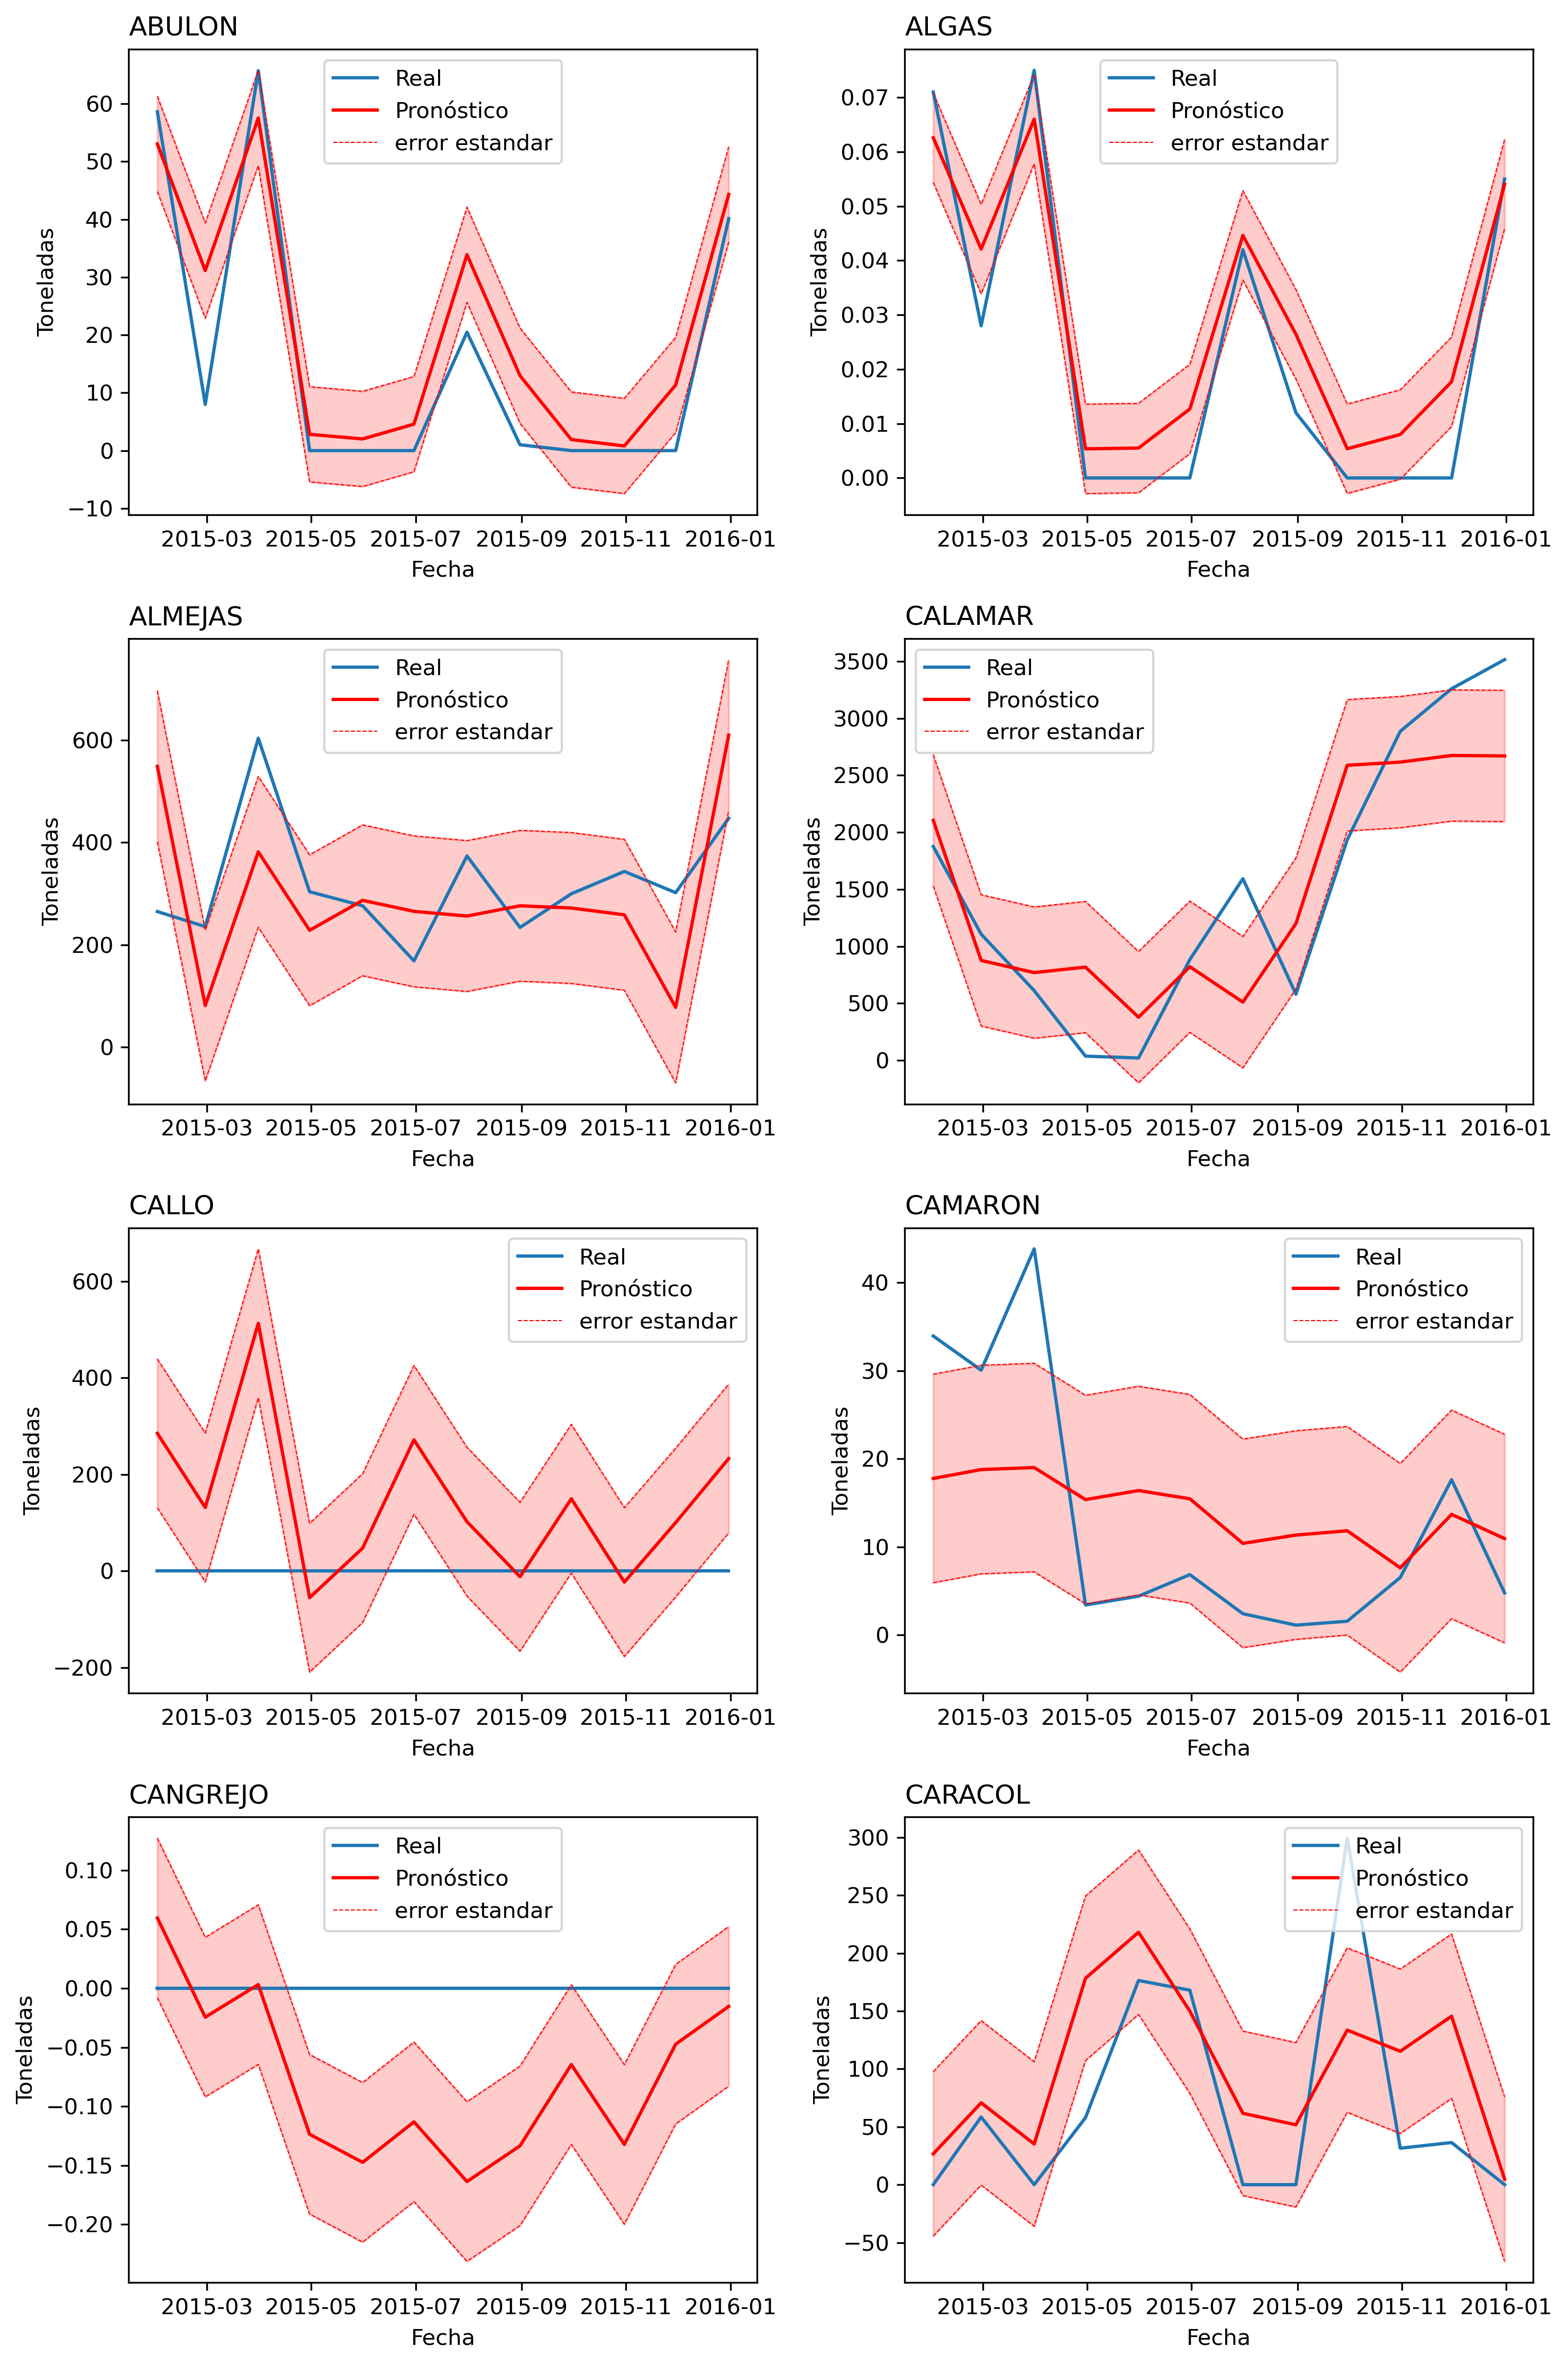

In [ ]:
import pandas as pd
fig = pyplot.figure(figsize=(10,15), dpi=300)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
dti = pd.date_range("2015-01-01", periods=12, freq="M")
for i in range(0,8):
        deltay= (inv_y3[:12,i]/1000)-inv_yhat3[:12,i]/1000
        prom=deltay.mean()
        desv=deltay.std()
        n=len(deltay)**(1/2)
        Za=1.28
        bc=Za*(desv/n)
        up=(inv_yhat3[:12,i]/1000)+desv
        down=(inv_yhat3[:12,i]/1000)-desv
        ax = pyplot.subplot(4,2,i+1)
        pyplot.plot(dti,inv_y3[:12,i]/1000, label = 'Real')
        pyplot.plot(dti,inv_yhat3[:12,i]/1000,'-r',label = 'Pronóstico')
        pyplot.plot(dti,up, 'r',  linestyle='dashed',linewidth=0.5,label="error estandar")
        pyplot.plot(dti,down, 'r',  linestyle='dashed',linewidth=0.5)
        pyplot.fill_between(dti,down,up,color='r',alpha=0.2)
        pyplot.title(dataset.columns[i],loc='left')
        pyplot.ylabel('Toneladas')
        pyplot.xlabel('Fecha')
        pyplot.legend()

fig.tight_layout()

pyplot.savefig('simulacion1.png')

In [ ]:
dti = pd.date_range("2016-01-01", periods=12, freq="M")

In [ ]:
dataset.columns

Index(['ABULON', 'ALGAS', 'ALMEJAS', 'CALAMAR', 'CALLO', 'CAMARON', 'CANGREJO',
       'CARACOL', 'DEPORTIVAS', 'ERIZO', 'ESCAMA', 'JAIBA', 'LANGOSTA',
       'OTRAS', 'TIBURON', 'TUNIDOS', 'sst', 'chlor_a', 'Rain'],
      dtype='object')

In [ ]:
len(inv_y3[:,15])


12